# K-Nearest Neighbors (KNN) for Termite Discovery Prediction

This notebook demonstrates the use of the K-Nearest Neighbors (KNN) algorithm to predict termite discovery based on various environmental and material features. We will go through the steps of loading the data, preprocessing it, and finally using KNN to make predictions. The goal is to understand how different features influence the likelihood of termite discovery.

## Data Loading

First, we load the necessary libraries and the dataset. We then display the first few rows to understand its structure.


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf

# Load the data
data = pd.read_csv('../../global_termite_microbe_wd.csv')  # Adjust the path as needed
data.head()

,country,site,latitude,longitude,habitat_type,wood_used,wood_origin,N_pc,C_pc,P_pc,...,treatment,deployment_date,harvest_date,date_diff,initial_wt,final_wt,k_value,termite_discovery,fungal_damage,termite_damage
0,Argentina,EntreRios,-32.771,-58.4512,Woody savannah,Pinus_radiata,Argentina,0.250763,46.553996,0.00737,...,C,10/11/2017,2018-11-15T00:00:00Z,400,128.253,124.455,0.027455,0.0,NaN,NaN
1,Argentina,EntreRios,-32.771,-58.4512,Woody savannah,Pinus_radiata,Argentina,0.250763,46.553996,0.00737,...,C,10/11/2017,2020-01-23T00:00:00Z,834,118.588,73.688,0.208385,0.0,NaN,NaN
2,Argentina,EntreRios,-32.771,-58.4512,Woody savannah,Pinus_radiata,Argentina,0.250763,46.553996,0.00737,...,T,10/11/2017,2018-11-15T00:00:00Z,400,139.887,102.724,0.281967,0.0,NaN,NaN
3,Argentina,EntreRios,-32.771,-58.4512,Woody savannah,Pinus_radiata,Argentina,0.250763,46.553996,0.00737,...,T,10/11/2017,2020-01-23T00:00:00Z,834,152.744,109.133,0.147238,0.0,NaN,NaN
4,Argentina,EntreRios,-32.771,-58.4512,Woody savannah,Pinus_radiata,Argentina,0.250763,46.553996,0.00737,...,C,10/11/2017,2018-11-15T00:00:00Z,400,163.892,155.943,0.045400,0.0,NaN,NaN


## Data Preprocessing

We perform several preprocessing steps to prepare the data for modeling:
- Drop rows with missing values in `termite_discovery`, ensuring our target variable is complete.
- Convert date fields to datetime and calculate the duration between deployment and harvest dates.
- Drop original date columns since they are no longer needed.
- Encode categorical variables and scale numerical variables to prepare for KNN.


In [45]:
# Drop rows where 'termite_discovery' is NaN
filtered_data = data.dropna(subset=['termite_discovery'])

# Convert date columns and calculate duration
filtered_data['deployment_date'] = pd.to_datetime(filtered_data['deployment_date']).dt.tz_localize(None)
filtered_data['harvest_date'] = pd.to_datetime(filtered_data['harvest_date']).dt.tz_localize(None)
filtered_data['duration_days'] = (filtered_data['harvest_date'] - filtered_data['deployment_date']).dt.days
filtered_data = filtered_data.drop(['deployment_date', 'harvest_date'], axis=1)

# Encoding and scaling
categorical_columns = ['country', 'site', 'habitat_type', 'wood_used', 'wood_origin', 'treatment', 'plot', 'tag']
filtered_data = pd.get_dummies(filtered_data, columns=categorical_columns)
numerical_columns = ['latitude', 'longitude', 'N_pc', 'C_pc', 'P_pc', 'Mg_pc', 'Ca_pc', 'K_pc', 'Al_pc', 'Mn_pc', 'date_diff', 'initial_wt', 'final_wt', 'k_value', 'duration_days']
scaler = StandardScaler()
filtered_data[numerical_columns] = scaler.fit_transform(filtered_data[numerical_columns])


C:\Users\isabe\AppData\Local\Temp\ipykernel_25540\2600004479.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['deployment_date'] = pd.to_datetime(filtered_data['deployment_date']).dt.tz_localize(None)
C:\Users\isabe\AppData\Local\Temp\ipykernel_25540\2600004479.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['harvest_date'] = pd.to_datetime(filtered_data['harvest_date']).dt.tz_localize(None)
C:\Users\isabe\AppData\Local\Temp\ipykernel_25540\2600004479.py:7: SettingWithCopy

## Understanding the K-Nearest Neighbors (KNN) Algorithm

K-Nearest Neighbors (KNN) is a simple, versatile, and easy-to-implement supervised machine learning algorithm used for both classification and regression tasks. However, it is more widely used for classification purposes. The core idea of KNN is to predict the label of a data point by looking at the 'k' closest labeled data points and taking a majority vote or averaging the labels.

### How Does KNN Work?

1. **Feature Similarity**: KNN operates on the principle of feature similarity. The closer the features of a new data point are to those of a data point in the training set, the more likely they are to share a label. This similarity is often calculated using distance metrics such as Euclidean distance, Manhattan distance, or Minkowski distance.

2. **Distance Metrics**:
   - **Euclidean Distance**: It is the most common distance metric, representing the shortest path between two points. It is used in a 2-D plane for calculating the direct line distance between two points.
   - **Manhattan Distance**: This metric sums up the absolute differences of their Cartesian coordinates. It is often used in urban settings, where paths must follow the grid layout.
   - **Minkowski Distance**: A generalized metric that includes others (such as Euclidean and Manhattan) as special cases. The formula involves a parameter, commonly referred to as 'p', which can be adjusted to represent different distance measures.

3. **Choosing the Right 'k'**: 
   - The choice of 'k' affects the performance of the KNN algorithm significantly. A smaller 'k' makes the algorithm sensitive to noise in the data, while a larger 'k' makes it computationally expensive and potentially overfitted to the training data.
   - Cross-validation can be used to find an optimal 'k' value that balances bias and variance, avoiding overfitting while still maintaining the ability to generalize well from the training data to unseen data.

4. **Algorithm Steps**:
   - A new data point is introduced.
   - Distances from this new point to all points in the training set are calculated.
   - Distances are sorted, and the nearest 'k' points are selected.
   - For classification, the most common label among the 'k' nearest points is assigned to the new point. For regression, the average or median of the 'k' nearest points is taken as the prediction.
### Application in Our Context

In our context of predicting termite discovery, KNN can help identify patterns based on geographical and chemical properties of the environment, potentially clustered by similar past instances of termite discoveries or non-discoveries. By tuning 'k' and carefully selecting features, we can potentially improve prediction accuracy and provide valuable insights into termite behavior and prevention strategies.


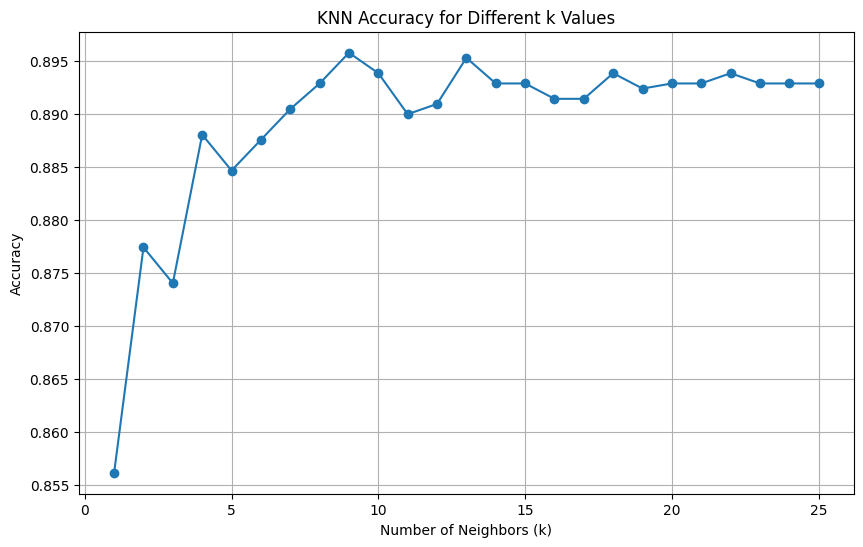

In [46]:
X = filtered_data[['N_pc', 'C_pc', 'P_pc', 'Mg_pc', 'Ca_pc', 'K_pc', 'Al_pc', 'Mn_pc'] + [col for col in filtered_data.columns if 'treatment_' in col] + [col for col in filtered_data.columns if 'habitat_type_' in col]]
y = filtered_data['termite_discovery']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Testing different k values
k_values = range(1, 26)  # Testing k from 1 to 25
accuracies = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different k Values')
plt.grid(True)
plt.show()


## Model Evaluation

After identifying the best `k` value, we evaluate the model's performance on the test set using classification metrics to understand its predictive accuracy. From the grpah above, the `k` value which results in the highest accuracy is 9.


In [47]:
# Evaluate with the best k value
best_k = accuracies.index(max(accuracies)) + 1
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
predictions = best_knn.predict(X_test)

# Classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))


              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      1792
         1.0       0.65      0.51      0.57       280

    accuracy                           0.90      2072
   macro avg       0.79      0.73      0.75      2072
weighted avg       0.89      0.90      0.89      2072



Overall, the accuracy of the model is 90%, meaning that it correctly predicts termite discovery for 90% of the cases in the dataset. This is a strong performance indicator for general predictions. 

However, while the precision, recalla and f1-scores are high for Class 0, they are comparatively very low for Class 1.The much higher number of instances in Class 0 (1792) compared to Class 1 (280) suggests a class imbalance that could be influencing the model’s performance, especially for Class 1. The model may be biased towards predicting the majority class (No Termite Discovery).

## Conclusion

The model performs very well overall but shows a bias towards predicting the absence of termite discovery more accurately than its presence. For practical applications, especially in scenarios where missing a termite discovery could lead to significant damage or cost, improving recall for termite discovery should be a priority. Additional strategies such as collecting more data, especially underrepresented classes, or trying more complex models might also yield better results.